In [1]:
learning_rate = 3e-4
number_of_epochs = 2
weight_decay = 0
kernel_size = 3
number_of_filters = [32,64,64]
loss_function = "MSELoss"
batch_size = 16

In [2]:
dataset_name = "CIFAR10" #should be CIFAR10, CelebA, or LFWPeople
CHK_PATH = "model.pt"

In [3]:
import os
import torch
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

from skimage import color, io
from torch.utils.data import random_split, Dataset, DataLoader
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import CelebA, CIFAR10, ImageNet, LFWPeople, Places365, STL10
from torchvision.io import read_image
from tqdm.auto import tqdm

%matplotlib inline

In [4]:
def Visualize(dataset,model):
    plt.ion()
    with torch.no_grad():

        # pick a random subset of images from the test set
        image_inds = np.random.choice(len(dataset), 25, replace=False)
        lab_batch = torch.stack([dataset[i][0] for i in image_inds])
        lab_batch = lab_batch.to(device)

        # predict colors (ab channels)
        predicted_ab_batch = model(lab_batch[:, 0:1, :, :])
        predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)

        lab_batch = lab_batch.cpu()
        predicted_lab_batch = predicted_lab_batch.cpu()

        # convert to rgb
        rgb_batch = []
        predicted_rgb_batch = []
        for i in range(lab_batch.size(0)):
            rgb_img = color.lab2rgb(np.transpose(lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
            rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))
            predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
            predicted_rgb_batch.append(torch.FloatTensor(np.transpose(predicted_rgb_img, (2, 0, 1))))

        # plot images
        fig, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=2)
        ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=5).numpy(), (1, 2, 0)))
        ax[0].title.set_text('re-colored')
        ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(rgb_batch), nrow=5).numpy(), (1, 2, 0)))
        ax[1].title.set_text('original')
        plt.show()

In [5]:
# converts the PIL image to a pytorch tensor containing an LAB image
def import_image(img):
    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2, 0, 1)))

In [6]:
from torchvision.datasets.coco import CocoDetection
def get_data(dataset_name):
    img_transform = transforms.Compose([
        transforms.Lambda(import_image)
        ])
    if dataset_name == "CIFAR10":
        test_dataset = CIFAR10('./data/CIFAR10', train=False, transform=img_transform, target_transform=None, download=True)
        train_dataset = CIFAR10('./data/CIFAR10', train=True, transform=img_transform, target_transform=None, download=True)
    elif dataset_name == "COCO":
        train_dataset = CocoDetection('./data/COCO', split='train', transform=img_transform, target_transform=None, download=True)
        test_dataset = CocoDetection('./data/COCO', split='test', transform=img_transform, target_transform=None, download=True)
    elif dataset_name == "LFWPeople":
        train_dataset = LFWPeople('./data/LFWPeople', split='train', transform=img_transform, target_transform=None, download=True)
        test_dataset = LFWPeople('./data/LFWPeople', split='test', transform=img_transform, target_transform=None, download=True)
    elif dataset_name == "Places365":
        train_dataset = Places365('./data/LFWPeople', split='train-standard', small=True, transform=img_transform, target_transform=None, download=True)
        test_dataset = Places365('./data/LFWPeople', split='val', small=True, transform=img_transform, target_transform=None, download=True)
    elif dataset_name == "STL10":
        train_dataset = STL10('./data/LFWPeople', split='train', transform=img_transform, target_transform=None, download=True)
        test_dataset = STL10('./data/LFWPeople', split='test', transform=img_transform, target_transform=None, download=True)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    return train_dataset, test_dataset, train_dataloader, test_dataloader

In [7]:
# Confirm we are running on GPU

torch.manual_seed(43)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"we are using {device}")

# torch.cuda.empty_cache()

we are using cuda


In [9]:
train_dataset, test_dataset, train_dataloader, test_dataloader = get_data("CIFAR10")

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


In [10]:
print(train_dataset)
print(test_dataset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data/CIFAR10
    Split: Train
    StandardTransform
Transform: Compose(
               Lambda()
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data/CIFAR10
    Split: Test
    StandardTransform
Transform: Compose(
               Lambda()
           )


In [ ]:
class ColorNet(nn.Module):
    def __init__(self, d=128):
        super(ColorNet, self).__init__()

        self.model = torchvision.models.segmentation.fcn_resnet50(True)
        self.model.classifier = torchvision.models.segmentation.fcn.FCNHead(2048, 2)
        self.model.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
    def forward(self, x):
        return self.model(x)["out"]

model = ColorNet()
model = model.to(device)
criterion = nn.MSELoss()
for param in model.parameters():
    param.requires_grad = False
for param in model.model.classifier.parameters():
    param.requires_grad = True
for param in model.model.backbone.conv1.parameters():
    param.requires_grad = True
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

try:
    checkpoint = torch.load(CHK_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
#     loss = checkpoint['loss']
except OSError as e:
    print(f"Check point doesn't exist on {CHK_PATH}.")

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

Check point doesn't exist on model.pt.


In [ ]:
#@title train function
def train(model, train_dataloader, criterion, optimizer, number_of_epochs, starting_epoch = 0):
    model.train()
    loss_arr = []
    loss_per_epochs_list = []

    for epoch in tqdm(range(starting_epoch, starting_epoch + number_of_epochs), desc="epoch"):
        for lab_batch, _ in tqdm(train_dataloader, desc="batch"):
            lab_batch = lab_batch.to(device)

            # apply the color net to the luminance component of the Lab images
            # to get the color (ab) components
            predicted_ab_batch = model(lab_batch[:, 0:1, :, :])

            # loss is the L2 error to the actual color (ab) components
            loss = criterion(predicted_ab_batch, lab_batch[:, 1:3, :, :])
            loss_arr.append(loss.item())

            # backpropagation
            optimizer.zero_grad()
            loss.backward()

            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()
        loss_per_epoch = test(model, train_dataloader, criterion)
        loss_per_epoch_validation = test(model, test_dataloader, criterion)
        loss_per_epochs_list.append(loss_per_epoch)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_per_epoch,
            'loss_validation': loss_per_epoch_validation
            }, CHK_PATH)
    
    return model, loss_arr, loss_per_epochs_list

In [ ]:
#@title test function
def test(model, test_dataloader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data[:, 0:1, :, :])
            test_loss += criterion(output, data[:, 1:3, :, :]).item()  # Sum up batch loss

    test_loss /= len(test_dataloader.dataset)
    return test_loss

In [ ]:
# train_model, loss_arr, loss_per_epochs_list = train(model, train_dataloader, criterion, optimizer, number_of_epochs, epoch)

# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.plot(loss_arr, label = 'batch')
# plt.plot(loss_per_epochs_list, label = 'epoch')
# plt.legend()
# plt.show()

In [ ]:
# Visualize(test_dataset, model)
# Visualize(train_dataset, model)

In [ ]:
# Number of channels in the training images. For color images this is 3
nc = 3


# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.AdaptiveAvgPool2d(1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netD = Discriminator().to(device)
netG = ColorNet().to(device)

## Loss function
criterion = nn.BCELoss()
criterion_2 = nn.MSELoss()
## Optimizer assignment
lr = 1e-4
beta1 = 0.5
optimizerD =  torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG =  torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

In [ ]:
img_list = []
G_losses = []
D_losses = []
G_losses_MSE = []
G_MSE_losses_test = []
iters = 0
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader):
        
        image,_ = data
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = image.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
#         print(output.shape,label.shape)
        
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
#       
        # Generate fake image batch with G
        fake = netG(image[:, 0:1].to(device))
        fake = torch.cat([image[:, 0:1].to(device), fake], dim=1)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        c2 = criterion_2(fake,real_cpu)
        errG = criterion(output, label) + c2* 0.05
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        G_losses_MSE.append(c2.item())
        iters += 1
        
#     netG.eval()
#     image_test,_ = test_dataloader
#     output_test = netG(image_test[:, 0:1].to(device))
#     output_test = torch.cat([image_test[:, 0:1].to(device), output_test], dim=1)
#     test_loss = criterion_2(output_test, image_test.to(device))
#     print(f'test_loss_MSE{test_loss.item()}')
#     G_MSE_losses_test.append(test_loss.item())
    test_loss = test(netG, test_dataloader, criterion_2)
    G_MSE_losses_test.append(test_loss)
    print(f'test_loss_MSE : {test_loss}')
    netG.train()

        # Check how the generator is doing by saving G's output on fixed_noise
#         if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_dataloader)-1)):
#             with torch.no_grad():
#                 fake = netG(fixed_noise).detach().cpu()
#             img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        

[0/20][0/1563]	Loss_D: 1.3982	Loss_G: 6.7362	D(x): 0.4753	D(G(z)): 0.4760 / 0.4599
[0/20][50/1563]	Loss_D: 1.0035	Loss_G: 7.1490	D(x): 0.5996	D(G(z)): 0.3820 / 0.3586
[0/20][100/1563]	Loss_D: 0.6871	Loss_G: 7.2151	D(x): 0.6887	D(G(z)): 0.2556 / 0.2343
[0/20][150/1563]	Loss_D: 1.0495	Loss_G: 7.3265	D(x): 0.4832	D(G(z)): 0.2559 / 0.2620
[0/20][200/1563]	Loss_D: 0.3941	Loss_G: 7.4331	D(x): 0.8357	D(G(z)): 0.1820 / 0.1548
[0/20][250/1563]	Loss_D: 0.6549	Loss_G: 8.3313	D(x): 0.7794	D(G(z)): 0.3258 / 0.1476
[0/20][300/1563]	Loss_D: 1.2594	Loss_G: 6.5856	D(x): 0.3578	D(G(z)): 0.1676 / 0.2574
[0/20][350/1563]	Loss_D: 0.3025	Loss_G: 7.7210	D(x): 0.8538	D(G(z)): 0.1230 / 0.1165
[0/20][400/1563]	Loss_D: 1.0604	Loss_G: 7.7502	D(x): 0.4249	D(G(z)): 0.1148 / 0.1942
[0/20][450/1563]	Loss_D: 0.1699	Loss_G: 7.5029	D(x): 0.9335	D(G(z)): 0.0952 / 0.0914
[0/20][500/1563]	Loss_D: 0.1517	Loss_G: 7.5842	D(x): 0.9345	D(G(z)): 0.0796 / 0.0742
[0/20][550/1563]	Loss_D: 1.7476	Loss_G: 11.0936	D(x): 0.9337	D(G(z))

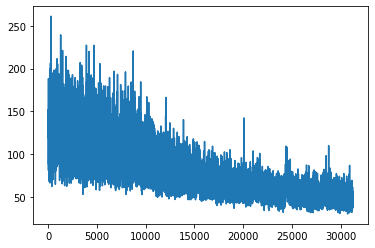

In [ ]:
plt.plot(G_losses_MSE)

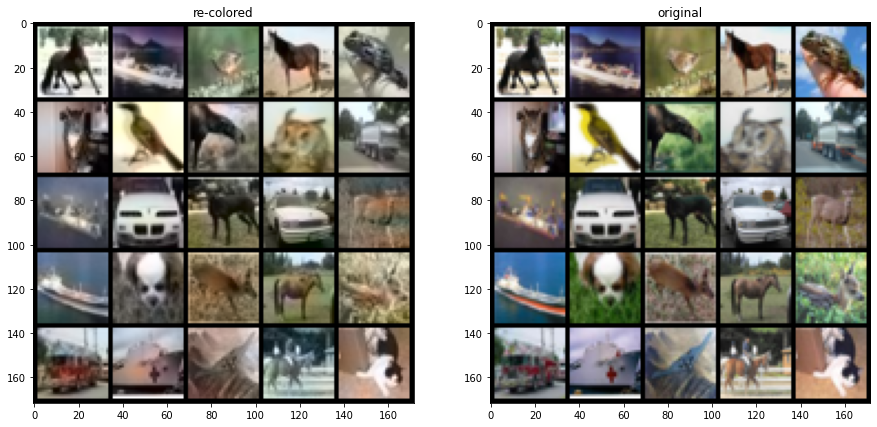

In [ ]:
Visualize(test_dataset, netG)